In [1]:
import sys, os
import pandas as pd
import pathSetting

sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")

from Clust.clust.ML.common.common import p1_integratedDataSaving as p1
from Clust.clust.ML.common.common import p2_dataSelection as p2
from Clust.clust.ML.common.common import p3_training as p3

/Users/kim-youngkee/Documents/CLUSTER/.clust/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Training 

## 2-1. Data selection

In [2]:
LearningMode = "train"
cleanParamList =["Clean", "NoClean"]
datasetNameList=['Hs1SwineFarmWithWeatherTime', 'gunwiStrawberryWithWeatherTime', 'strawberryOpenTime']

DataMeta = p1.read_json_data(pathSetting.DataMetaPath)

In [3]:
### 1-1. Change Variables#########################################################################
datasetName = datasetNameList[0]
cleanMode = cleanParamList[1]
#################################################################################################

In [4]:
datasetName

'Hs1SwineFarmWithWeatherTime'

In [5]:
dataName = LearningMode+cleanMode+'_'+datasetName
dataSaveMode = DataMeta[dataName]["integrationInfo"]["DataSaveMode"]
print(dataName)

data = p2.get_saved_integrated_data(dataSaveMode, dataName, pathSetting.dataFolderPath)
integration_freq_sec = DataMeta[dataName]["integrationInfo"]["integration_freq_sec"]

# Data Preparation Parameters
print(data.columns)
featureList= ['Temperature', 'out_temp','sin_hour']# 'sin_hour' 할 수 있도록 DB/MS 조절해야함
target_col = 'Temperature'
scalerParam='scale'
scaleMethod ='robust'

# cleanMode == Clean 일 때만 활성화
NaNProcessingParam ={
    "feature_cycle":'Day',
    "feature_cycle_times":1,
    "NanInfoForCleanData":{'type':'num', 'ConsecutiveNanLimit':3, 'totalNaNLimit':30000}
}
splitRatio = 0.8

scalerRootPath = os.path.join(pathSetting.scalerRootDir, dataName, cleanMode)
train, val, scalerFilePath = p3.get_train_val_data(data, featureList, scalerRootPath, splitRatio, scalerParam, scaleMethod)
print(len(train), len(val))
print(train[[target_col]].tail())
train, val = p3.delete_low_quality_train_val_data(train, val, cleanMode, integration_freq_sec, NaNProcessingParam)
print(len(train), len(val))
print(train[[target_col]].tail())

# 해당 코드를 보면, 끝이 다릅니다. Cycle로 데이터 처리하면서 뒷부분을 날려버리는거 같아요 왜죠?

trainNoClean_Hs1SwineFarmWithWeatherTime
Index(['CO2ppm', 'H2Sppm', 'Humidity', 'NH3ppm', 'Temperature', 'out_humid',
       'out_pressure', 'out_rainfall', 'out_sunshine', 'out_temp',
       'out_wind_direction', 'out_wind_speed', 'cos_day_of_week', 'cos_hour',
       'cos_month', 'cos_week_of_year', 'sin_day_of_week', 'sin_hour',
       'sin_month', 'sin_week_of_year'],
      dtype='object')
['Temperature', 'out_temp', 'sin_hour']
Make New scaler File
8516 2129
                           Temperature
datetime                              
2021-03-02 13:15:00+00:00     0.120172
2021-03-02 13:20:00+00:00     0.107296
2021-03-02 13:25:00+00:00     0.107296
2021-03-02 13:30:00+00:00     0.120172
2021-03-02 13:35:00+00:00     0.120172
------ {'feature_cycle': 'Day', 'feature_cycle_times': 1, 'NanInfoForCleanData': {'type': 'num', 'ConsecutiveNanLimit': 3, 'totalNaNLimit': 30000}}
8516 2129
                           Temperature
datetime                              
2021-03-02 13:15:00+00:

(8516, 3)


<AxesSubplot: xlabel='datetime'>

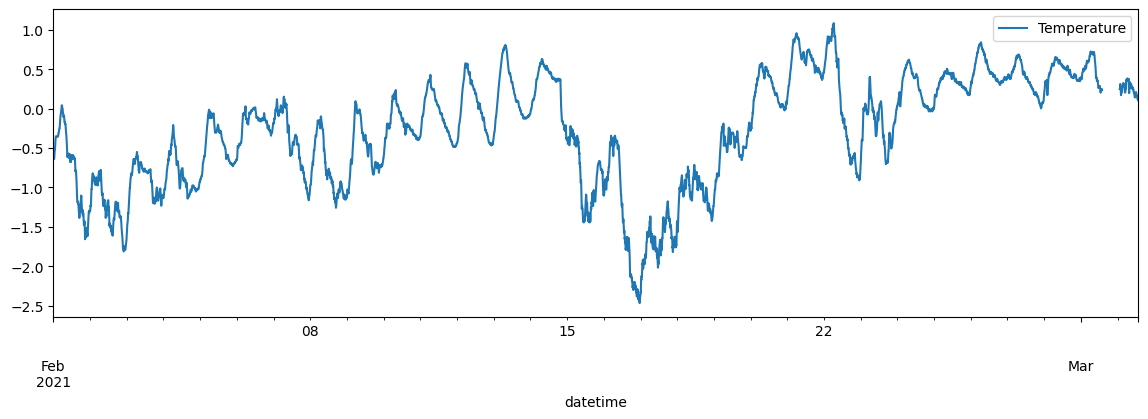

In [6]:
print(train.shape)
train[[target_col]].plot()

(2129, 3)


<AxesSubplot: xlabel='datetime'>

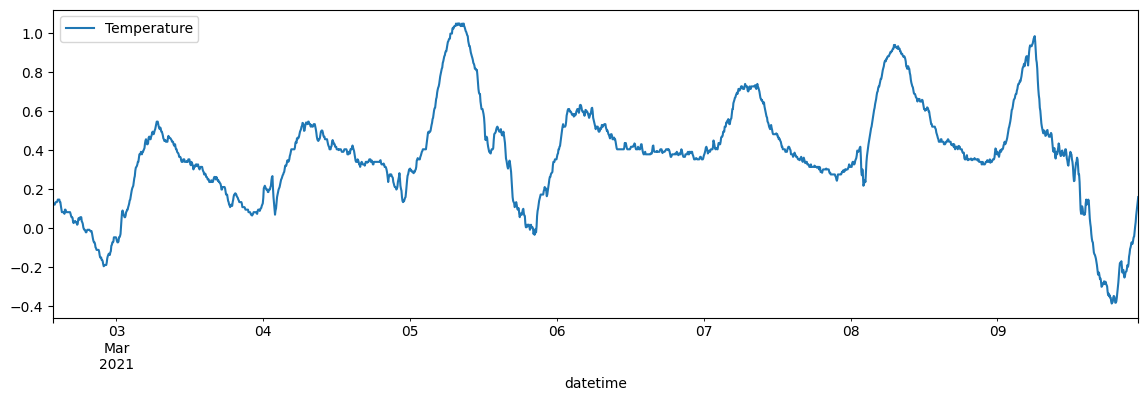

In [7]:
print(val.shape)
val[[target_col]].plot()

In [8]:
model_method ="gru"
batch_size = 64
n_epochs= 10

# trainParameter = {'input_dim': len(featureList),
#                 'hidden_dim' : 256,
#                 'layer_dim' : 3,
#                 'output_dim' : 1,
#                 'dropout_prob' : 0.2}
trainParameter = {'input_size': len(featureList),
                'hidden_size' : 256,
                'num_layers' : 3,
                'output_dim' : 1,
                'dropout_prob' : 0.2}

transformParameter ={
    "future_step": 2,# 0~x
    "past_step":24,# 1~y
    "feature_col": featureList,
    "target_col":target_col 
}   
modelTags =["farm", "HS2", "prediction"]
trainDataType = "timeseries"
modelPurpose = "forecasting"

# 2
trainDataInfo = DataMeta[dataName]['integrationInfo']

# 3. 모델 파일 패스를 생성한다.
#ModelName = encode_hash_style(p1.get_list_merge ([model_method, cleanMode, trainParameter_encode, dataName] ))
ModelName = dataName+'_'+model_method

from Clust.clust.transformation.general.dataScaler import encode_hash_style
transformParameter_encode =  encode_hash_style(str(transformParameter))
trainDataPathList = [dataName, transformParameter_encode]

from Clust.clust.ML.common import model_manager
modelFilePath = model_manager.get_model_file_path(trainDataPathList, model_method)
# modelFilePath = p3.getModelFilePath(trainDataPathList, model_method)

./Models/gru/trainNoClean_Hs1SwineFarmWithWeatherTime/825a1196dda25f71929140240c251257/model_state_dict.pkl


In [9]:
# 4. Training
param = {
    "clean_param": cleanMode,
    "transform_parameter": transformParameter,
    "batch_size": batch_size,
    "train_parameter": trainParameter,
    "n_epochs": n_epochs,
    "device": "cpu",
}

# from Clust.clust.ML.forecasting.train import ForecastingTrain
from Clust.clust.ML.regression_YK.train_forecast import ForecastTrain
Ftrain= ForecastTrain()

Ftrain.set_param(param)
Ftrain.set_model(model_method)
Ftrain.set_data(train, val)
Ftrain.train()
Ftrain.save_best_model("./yk_gru_test.pkl")
model = Ftrain.export()

# RM.processInputData(train, val, transformParameter, cleanMode, batch_size)

# RM.setTrainParameter(trainParameter)
# RM.getModel(model_method)
# RM.trainModel(n_epochs)

1. Original Data Lenagh: 8514
2. Removed Data Length: 0
3. Clean Data Leangth: 8491
1. Original Data Lenagh: 2127
2. Removed Data Length: 0
3. Clean Data Leangth: 2104
Start training model
[1/10] Training loss: 0.1153	 Validation loss: 0.0165
[2/10] Training loss: 0.0221	 Validation loss: 0.0017
[3/10] Training loss: 0.0109	 Validation loss: 0.0019
[4/10] Training loss: 0.0124	 Validation loss: 0.0021
[5/10] Training loss: 0.0139	 Validation loss: 0.0016
[6/10] Training loss: 0.0137	 Validation loss: 0.0016
[7/10] Training loss: 0.0149	 Validation loss: 0.0013
[8/10] Training loss: 0.0126	 Validation loss: 0.0015
[9/10] Training loss: 0.0176	 Validation loss: 0.0016
[10/10] Training loss: 0.0132	 Validation loss: 0.0014

Training complete in 4m 50s


In [16]:
from Clust.clust.ML.tool import model as model_manager
from Clust.clust.ML.tool import meta
model_manager.save_pickle_model(model, modelFilePath)

In [17]:
from Clust.clust.ingestion.mongo.mongo_client import MongoClient
from Clust.setting import influx_setting_KETI as ins
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

In [18]:
# 5. update MetaFile
from Clust.clust.transformation.general.dataScaler import encode_hash_style
trainParameter_encode =  encode_hash_style(str(trainParameter))
modelInfoMeta ={
    "trainDataInfo":trainDataInfo,
    "modelName":ModelName,
    "featureList":transformParameter["feature_col"],
    "trainDataType":trainDataType,
    "modelPurpose":modelPurpose,
    "model_method":model_method,
    "modelTags":modelTags,
    "cleanTrainDataParam":cleanMode,
    "NaNProcessingParam":NaNProcessingParam,
    "trainDataName":datasetName,
    "transformParameter":transformParameter,
    "NaNProcessingParam":NaNProcessingParam,
    "scalerParam":scalerParam,
    "files":{
        "modelFile":{
            "fileName":"model.pth",
            "filePath":modelFilePath
        },
        "scalerFile":{
            "fileName":"scaler.pkl",
            "filePath":scalerFilePath       
        }
    },
    "trainParameter":trainParameter

}
# modelInfoMeta1 = p3.updateModelMetaData(ModelName, modelInfoMeta, pathSetting.trainModelMetaFilePath)

modelInfoMeta2 = meta.save_model_meta_data(mongo_client, modelInfoMeta)


========== Data Svae Success ==========
{'trainDataInfo': {'startTime': '2021-02-01 00:00:00', 'endTime': '2021-03-10 00:00:00', 'dataInfo': [['farm_swine_air', 'HS2'], ['weather_outdoor_keti_clean', 'sangju'], ['life_additional_Info', 'trigonometicInfoByHours']], 'processParam': {'refine_param': {'removeDuplication': {'flag': False}, 'staticFrequency': {'flag': False, 'frequency': None}}, 'outlier_param': {'certainErrorToNaN': {'flag': False}, 'unCertainErrorToNaN': {'flag': False, 'param': {}}}, 'imputation_param': {'flag': False, 'imputation_method': [], 'totalNonNanRatio': 80}}, 'integration_freq_sec': 300, 'cleanParam': 'NoClean', 'DataSaveMode': 'CSV'}, 'modelName': 'trainNoClean_Hs1SwineFarmWithWeatherTime_gru', 'featureList': ['Temperature', 'out_temp', 'sin_hour'], 'trainDataType': 'timeseries', 'modelPurpose': 'forecasting', 'model_method': 'gru', 'modelTags': ['farm', 'HS2', 'prediction'], 'cleanTrainDataParam': 'NoClean', 'NaNProcessingParam': {'feature_cycle': 'Day', 'feat

In [13]:
modelInfoMeta2